# Playground Series, S03, E03, IBM HR Analytics+Notebook+Submission

It's  my first ever sumbission for Kaggle Competitions. If you find it useful then please upvote my efforts.

In this competition we will be using data generated by a deep learning model trained on the [IBM HR Analytics Employee Attrition & Performance dataset](https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset). 

Data files are: train.csv, test.csv and sample_submission.csv
The `id` column is non-overlapping between `train` and `test`.

The target (`Attrition`) is a binary variable and hence, the evaluation metric for this competition has been selected to be the [area under the ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) between the predicted probability and the observed target.


### Getting Started

Choose the binary classification algorithm then import the required libraries and load the data.

In [1]:
%config IPCompleter.greedy=True
!pip install imblearn 
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, roc_curve, auc, precision_score, plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample


In [2]:
# eliminating annoying lgbm warnings, source: https://stackoverflow.com/a/33616192/1105837
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
DataPath = Path('C:/Users/Admin/Documents/Kaggle/PlaygroundSeries/Season3/playground-series-s3e3')
train_df = pd.read_csv(DataPath/'train.csv', index_col='id')

In [4]:
train_df.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
id,,,,,,,,,,,,,,,,,,,,,
0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,Male,...,80,1,10,2,3,10,0,7,8,0
1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,Male,...,80,1,4,3,3,4,2,0,3,0
2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,Male,...,80,2,4,3,3,3,2,1,2,0
3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,Female,...,80,0,15,1,1,6,0,0,2,0
4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,Female,...,80,0,31,0,3,31,14,4,10,1


Now that we have loaded the data, let's take a closer Look

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1677 entries, 0 to 1676
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1677 non-null   int64 
 1   BusinessTravel            1677 non-null   object
 2   DailyRate                 1677 non-null   int64 
 3   Department                1677 non-null   object
 4   DistanceFromHome          1677 non-null   int64 
 5   Education                 1677 non-null   int64 
 6   EducationField            1677 non-null   object
 7   EmployeeCount             1677 non-null   int64 
 8   EnvironmentSatisfaction   1677 non-null   int64 
 9   Gender                    1677 non-null   object
 10  HourlyRate                1677 non-null   int64 
 11  JobInvolvement            1677 non-null   int64 
 12  JobLevel                  1677 non-null   int64 
 13  JobRole                   1677 non-null   object
 14  JobSatisfaction         

Ok, so we have 1677 data points each with 34 variables

In [6]:
original_df = pd.read_csv(DataPath/'Original.csv', index_col='EmployeeNumber')

In [7]:
original_df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,...,1,80,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,3,...,4,80,1,10,3,3,10,7,1,7
4,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
5,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,4,...,3,80,0,8,3,3,8,7,3,0
7,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,1,...,4,80,1,6,3,3,2,2,2,2


In [8]:
original_df = original_df.rename(columns={'EmployeeNumber': 'id'})
original_df['Attrition'] = (original_df['Attrition'] == 'Yes').astype(int)

In [9]:
train_df = pd.concat([train_df, original_df])
train_df.reset_index(inplace=True, drop=True)

### Variable Types

Before we go any further it is important to understand the type of data stored in our columns


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3147 entries, 0 to 3146
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       3147 non-null   int64 
 1   BusinessTravel            3147 non-null   object
 2   DailyRate                 3147 non-null   int64 
 3   Department                3147 non-null   object
 4   DistanceFromHome          3147 non-null   int64 
 5   Education                 3147 non-null   int64 
 6   EducationField            3147 non-null   object
 7   EmployeeCount             3147 non-null   int64 
 8   EnvironmentSatisfaction   3147 non-null   int64 
 9   Gender                    3147 non-null   object
 10  HourlyRate                3147 non-null   int64 
 11  JobInvolvement            3147 non-null   int64 
 12  JobLevel                  3147 non-null   int64 
 13  JobRole                   3147 non-null   object
 14  JobSatisfaction         

Now we know we have 2 data types:
- int64 (whole number)
- object (string or non-numeric)

And there are no missing values.

### Explore the Target Variable
How many people quit their jobs?

In [11]:
train_df['Attrition'].value_counts()

0    2710
1     437
Name: Attrition, dtype: int64

We can see that out of 1677, there are 200 who quit.

The 'normalize' parameter lets us use value_counts to get a percentage

In [12]:
train_df['Attrition'].value_counts(normalize=True)

0    0.861138
1    0.138862
Name: Attrition, dtype: float64

The rate of Attrition is about 12% keep this in mind!

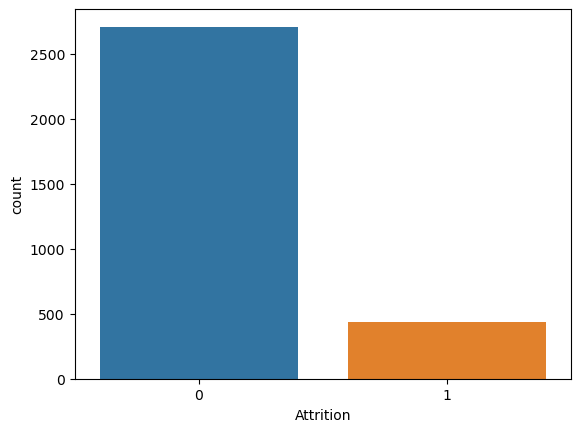

In [13]:
sns.countplot(x="Attrition", data=train_df)
plt.show()

## Exploratory Data Analysis

Let's dive deep!

In [14]:
train_df.nunique()

Age                           43
BusinessTravel                 3
DailyRate                    901
Department                     3
DistanceFromHome              29
Education                      6
EducationField                 6
EmployeeCount                  1
EnvironmentSatisfaction        4
Gender                         2
HourlyRate                    71
JobInvolvement                 4
JobLevel                       6
JobRole                        9
JobSatisfaction                4
MaritalStatus                  3
MonthlyIncome               1383
MonthlyRate                 1447
NumCompaniesWorked            10
Over18                         1
OverTime                       2
PercentSalaryHike             15
PerformanceRating              2
RelationshipSatisfaction       4
StandardHours                  1
StockOptionLevel               4
TotalWorkingYears             41
TrainingTimesLastYear          7
WorkLifeBalance                4
YearsAtCompany                38
YearsInCur

- Did you notice that EmployeeCount, Over18 and StandardHours have only one unique value.
- There are three binary variables namely Gender, OverTime and PerformanceRating.

Let's look in more detail.

In [15]:
print(train_df['EmployeeCount'].value_counts())
print(train_df['Over18'].value_counts())
print(train_df['StandardHours'].value_counts())

1    3147
Name: EmployeeCount, dtype: int64
Y    3147
Name: Over18, dtype: int64
80    3147
Name: StandardHours, dtype: int64


All three of them have constant values, meaning no predictive value so we can drop them.

### EDA Findings

I'm skipping the long EDA for each feature. Below are the key findings for reference. 
- The younger the more likely to quit. Majority under the group 28-37.
- Employees traveling frequently are more likely to quit. 
- DailyRate of those who quit are slightly lower than others. 50% are below 790.
- Department:
    - Research & Development has the highest number of Attrition but ratio wise Human Resources has the highest Attrition Rate of around 18%.
    - Hence, R&D and HR both are prone to Attrition.
- Those who quit have a mean DistanceFromHome of around 9.98. Others have 8.75.
- Education level 1 have highest Attrition rate.
- EducationField:
    - Count wise Life Sciences leading the Attrition.
    - As expected HR education field has the highest Attrition of around 23%.
- EnvironmentSatisfaction: The least satisfied have highest Attrition rate of around 21.7%. Count wise rating 3 is second leading category.
- Males are excited about change.
- Those who quit had a mean of 65.69 and 75% are below 83.
- JobInvolvement rating 1 is leading with 33% Attrition rate. Count wise it's rating 3.
- JobLevel 1 have the highest Attrition rate of 22.5%.
- JobRole:
    - Count wise Laboratory Technician leading the Attrition.
    - Sales Representatives leading the Attrition ratio. And they are the frequent travellers as well.
- JobSatisfaction: Majority falls under least satisfied with 18.8% Attrition rate.    
- As expected Singles are more likely to leave.
- MonthlyIncome is playing a big role. 50% those who quit are below 3000 as compared to others (nearly 5000).
- MonthlyRate is marginally better than others with mean around 14607.
- 50% of those who quit had worked for only 1 company. And another 25% worked for 5.
- People doing overtime has 26% Attrition rate. But count wise others are leading with 222 against 215 with overtime. 
- Comparatively similar SalaryHike. Those who quit have a mean around 14.87 against 15.07.
- PerformanceRating is a binary variable with only two levels 3 & 4. Attrition rate difference is only around 1% with maority count rated 3.
- RelationshipSatisfaction:
   - count wise rating 3 have highest number of Attritions.
   - rate wise rating 1 is leading with 19.6%
- 0 StockOptionLevel leading with 22.5% Attrition rate.
- Those who quit had a mean of around 8 Years of TotalWorkingYears and 75% lies under 10 years.
- 0 TrainingTimesLastYear have the highest Attrition rate of around 26%.
- 1 TrainingTimesLastYear have the least Attrition rate of around 7%.
- WorkLifeBalance with 3 have more Attrition count but rating 1 have higher Attrition rate of around 26.5%.
- Those who quit had a mean of around 5 years for YearsAtCompany. So first 5 years are crucial for new employees.
- YearsInCurrentRole: As expected first 5 years are crucial to decide whether to stay or not.
- Majority falls under 0-2 years promotion.
- Majority of those who quit falls uder 5 years with CurrManager.

## Feature Engineering

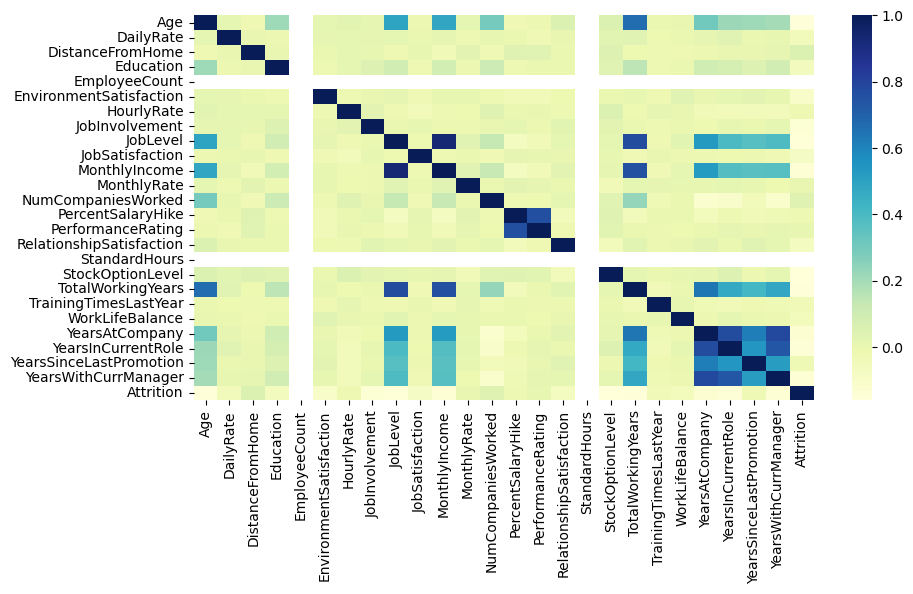

In [16]:
fig = plt.figure(figsize=(10, 5), dpi=100)
sns.heatmap(train_df.corr(), cmap='YlGnBu')
plt.show()

In [17]:
def encode_and_split(train_df):
    train_df=train_df.drop(['EmployeeCount','Over18','StandardHours'],axis=1)
    category_cols= ['BusinessTravel','Department','EducationField','Gender','JobRole','MaritalStatus','OverTime']
    train_df[category_cols] = train_df[category_cols].astype('category')
    train_df[category_cols].dtypes
    
    train_dumm = pd.get_dummies(train_df, prefix_sep='_', drop_first=True)

    x = train_dumm.drop(['Attrition'], axis=1)
    y = train_dumm['Attrition']

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

    return x_train, x_test, y_train, y_test

In [18]:
x_train, x_test, y_train, y_test= encode_and_split(train_df)

In [19]:
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.860946
1    0.139054
Name: Attrition, dtype: float64
0    0.861905
1    0.138095
Name: Attrition, dtype: float64


In [20]:
y_train.value_counts()

0    2167
1     350
Name: Attrition, dtype: int64

In [21]:
y_test.value_counts()

0    543
1     87
Name: Attrition, dtype: int64

## Cross Validation

cross_val can simplify the whole process of stratification & kfolds in one go.

In [22]:
lgbm_model= LGBMClassifier(n_estimators=100)
lgbm_model.fit(x_train,y_train)

cross_val_score(lgbm_model,x_test, y_test,cv=14).mean()

0.8730158730158732

In [23]:
rfc_model= RandomForestClassifier(n_estimators=40,max_depth=14)
rfc_model.fit(x_train,y_train)
cross_val_score(rfc_model,x_test, y_test,cv=14).mean()

0.8666666666666669

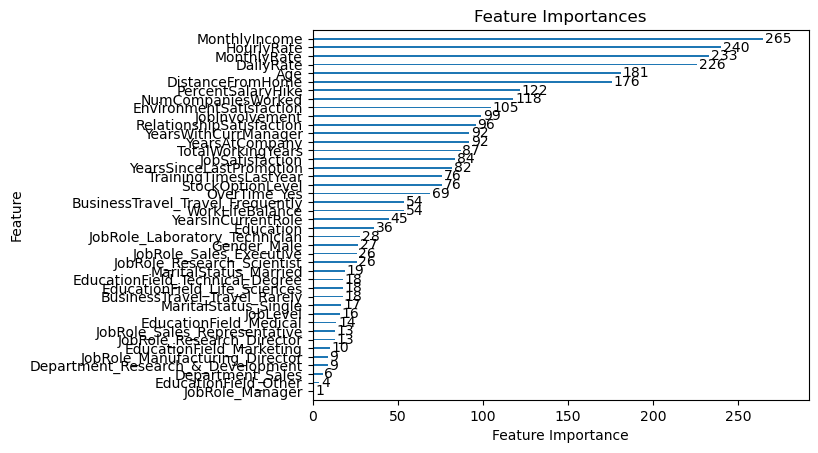

In [24]:
# Plot feature importances 
lgb.plot_importance(lgbm_model, importance_type='split',  
                   title='Feature Importances',
                   xlabel='Feature Importance', ylabel='Feature', grid=False)
plt.show()

In [53]:
print(lgbm_model.feature_importances_)

[188 191 153  35  88 226  74  12  78 208 181  86 122   0  86  78  82  60
  28  87  69  81  87  43   8  19  26  34   4   7   0  11  19   0  15   0
   4   0  11  13   9  23  15  71]


In [55]:
def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

In [57]:
plotImp(lgbm_model,x_train)

AttributeError: 'LGBMClassifier' object has no attribute 'feature_importance'

In [58]:
import pandas as pd

def get_lgbm_varimp(model, train_columns, max_vars=50):
    
    if "basic.Booster" in str(model.__class__):
        # lightgbm.basic.Booster was trained directly, so using feature_importance() function 
        cv_varimp_df = pd.DataFrame([train_columns, model.feature_importance()]).T
    else:
        # Scikit-learn API LGBMClassifier or LGBMRegressor was fitted, 
        # so using feature_importances_ property
        cv_varimp_df = pd.DataFrame([train_columns, model.feature_importances_]).T

    cv_varimp_df.columns = ['feature_name', 'varimp']

    cv_varimp_df.sort_values(by='varimp', ascending=False, inplace=True)

    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]   

    return cv_varimp_df

In [62]:
feat_imp= get_lgbm_varimp(lgbm_model, x_train, max_vars=50)

C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


In [64]:
feat_imp.head()

,feature_name,varimp
0,Age DailyRate DistanceFromHome Educat...,"[188, 191, 153, 35, 88, 226, 74, 12, 78, 208, ..."


## Model Evaluation

In [25]:
def eval_model(model, x_test, y_test):
    
    preds = model.predict(x_test)
    probs = model.predict_proba(x_test)

    accuracy = accuracy_score(y_test, preds)
    recall = recall_score(y_test, preds)
    precision = precision_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    ConfusionMatrixDisplay.from_estimator(model, x_test, y_test)
    plt.show()

    print("\n")
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1: ", f1)

    roc_auc= roc_auc_score(y_test, probs[:,1])
    print("AUC: ", roc_auc)

    RocCurveDisplay.from_estimator(model,x_test,y_test)
    plt.show()

    results_df = pd.DataFrame()
    results_df['true_class'] = y_test
    results_df['predicted_class'] = list(preds)
    results_df['attrition_prob'] = probs[:, 1]

    #plot the distribution of probabilities for the estimated classes 
    sns.kdeplot(results_df[results_df['true_class'] == 0]['attrition_prob'], label="No Attrition")
    sns.kdeplot(results_df[results_df['true_class'] == 1]['attrition_prob'], label="Attrition")
    plt.show()
    
    #see the true class versus predicted class as a percentage
    print(results_df.groupby('true_class')['predicted_class'].value_counts(normalize=True))

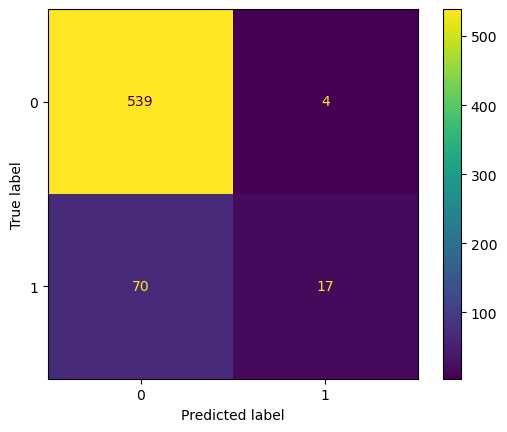



Accuracy:  0.8825396825396825
Precision:  0.8095238095238095
Recall:  0.19540229885057472
F1:  0.3148148148148148
AUC:  0.8097944582036791


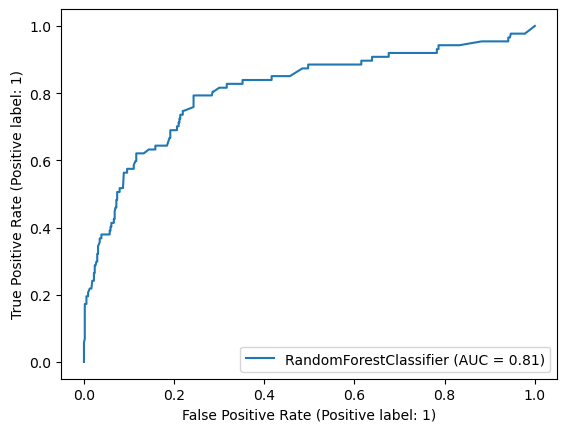

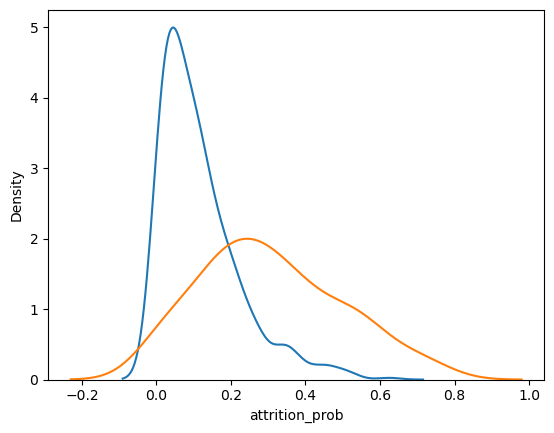

true_class  predicted_class
0           0                  0.992634
            1                  0.007366
1           0                  0.804598
            1                  0.195402
Name: predicted_class, dtype: float64


In [26]:
eval_model(rfc_model, x_test, y_test)

**Did you notice that AUC alone can be a misleading metric? Despite good AUC our model is not able to predict the Attrition correctly.**

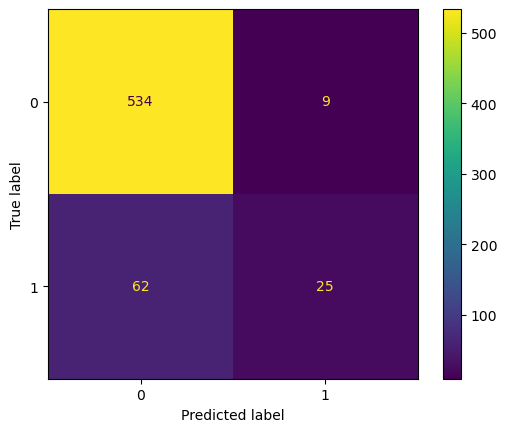



Accuracy:  0.8873015873015873
Precision:  0.7352941176470589
Recall:  0.28735632183908044
F1:  0.4132231404958677
AUC:  0.8363709489638237


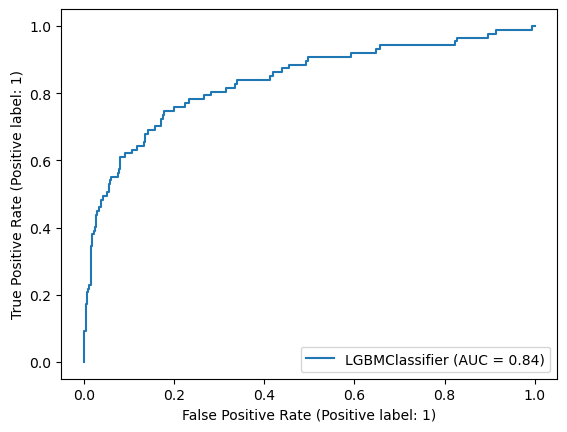

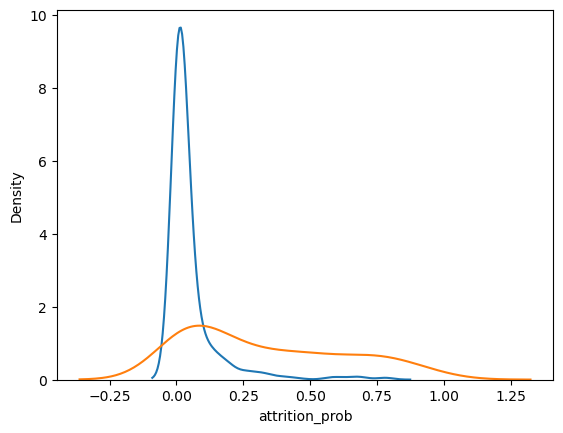

true_class  predicted_class
0           0                  0.983425
            1                  0.016575
1           0                  0.712644
            1                  0.287356
Name: predicted_class, dtype: float64


In [27]:
eval_model(lgbm_model, x_test, y_test)

**LGBM is better but still not that good enough in predictions.**

### Investigate Overfitting

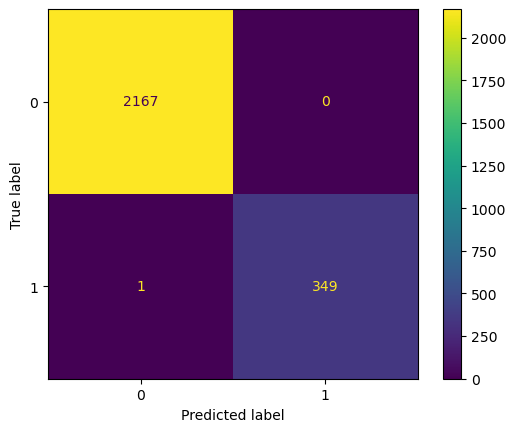



Accuracy:  0.9996027016289233
Precision:  1.0
Recall:  0.9971428571428571
F1:  0.9985693848354792
AUC:  1.0


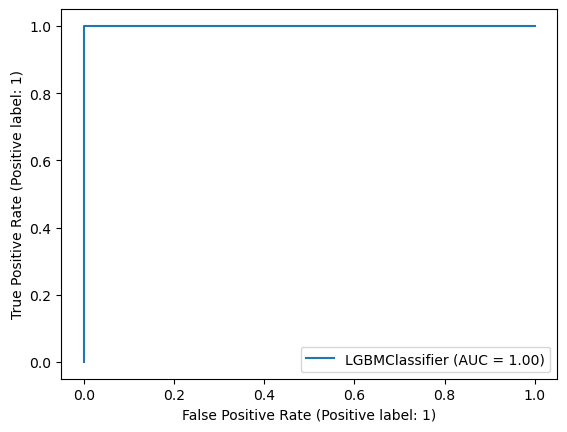

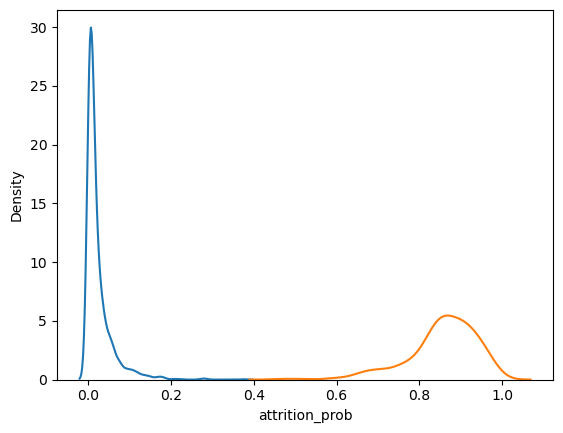

true_class  predicted_class
0           0                  1.000000
1           1                  0.997143
            0                  0.002857
Name: predicted_class, dtype: float64


In [28]:
eval_model(lgbm_model, x_train, y_train)

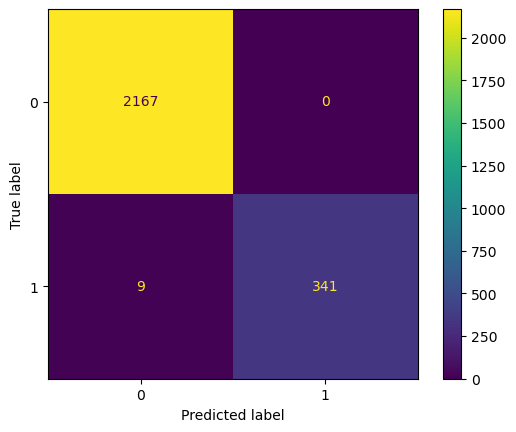



Accuracy:  0.9964243146603099
Precision:  1.0
Recall:  0.9742857142857143
F1:  0.9869753979739508
AUC:  1.0


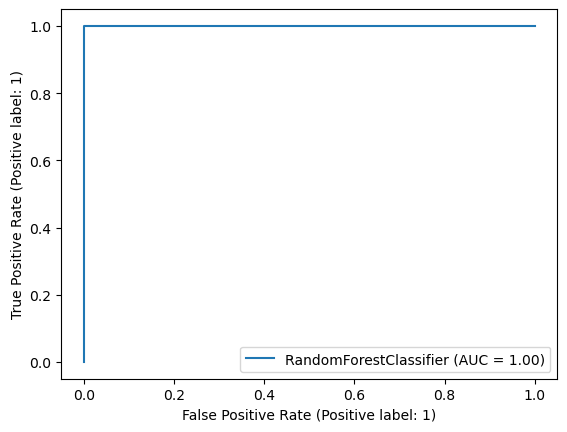

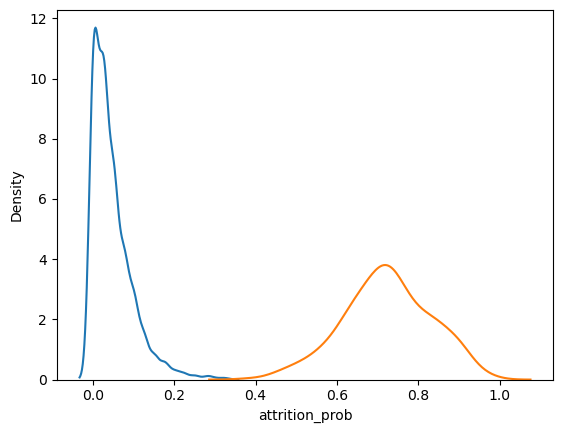

true_class  predicted_class
0           0                  1.000000
1           1                  0.974286
            0                  0.025714
Name: predicted_class, dtype: float64


In [29]:
eval_model(rfc_model, x_train, y_train)

**Both LGBM and RandomForest are clearly overfitting.**

### Resampling

In [30]:
def balance_sample(x_train, y_train, sample_mode='down'):
    train_df = x_train.copy()
    train_df['Attrition'] = y_train

    train_minority = train_df[train_df['Attrition'] == 1]
    train_majority = train_df[train_df['Attrition'] == 0]

    train_sampled_df = pd.DataFrame()

    if sample_mode == 'down':
        train_majority_down = resample(train_majority, replace=False,  n_samples=train_minority.shape[0], random_state=123)
        train_sampled_df = pd.concat([train_minority, train_majority_down])  
    else:
        train_minority_up = resample(train_minority, replace=True,  n_samples=train_majority.shape[0], random_state=123)
        train_sampled_df = pd.concat([train_majority, train_minority_up])

    x_train_samp = train_sampled_df.drop(['Attrition'], axis=1)
    y_train_samp = train_sampled_df['Attrition']

    return x_train_samp, y_train_samp

In [31]:
#downsample 
x_train_dwn, y_train_dwn = balance_sample(x_train, y_train, sample_mode='down')

print(y_train_dwn.value_counts())
print(y_train_dwn.value_counts(normalize=True))

1    350
0    350
Name: Attrition, dtype: int64
1    0.5
0    0.5
Name: Attrition, dtype: float64


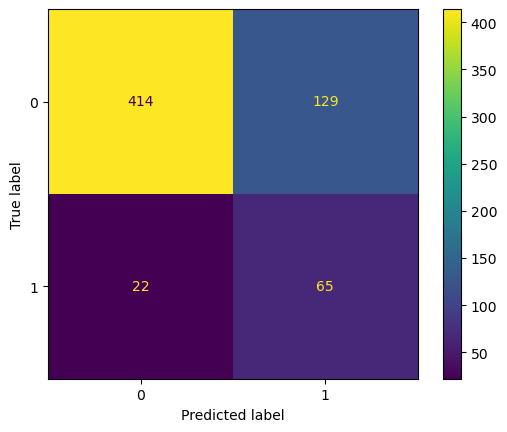



Accuracy:  0.7603174603174603
Precision:  0.33505154639175255
Recall:  0.7471264367816092
F1:  0.4626334519572953
AUC:  0.8128214898075824


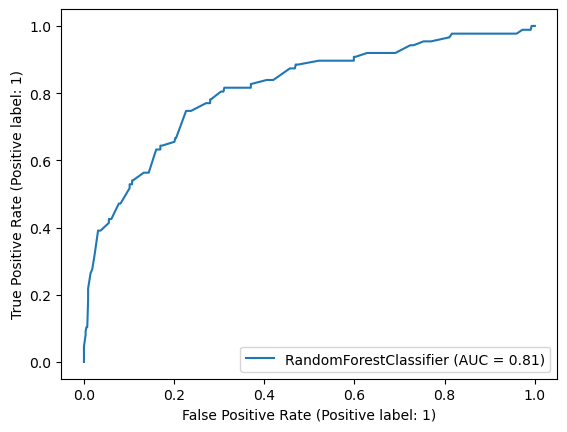

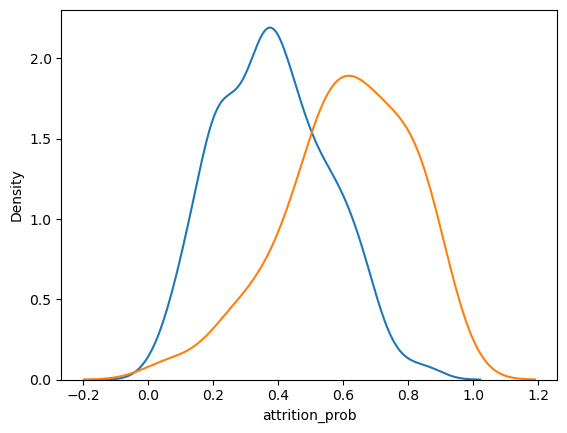

true_class  predicted_class
0           0                  0.762431
            1                  0.237569
1           1                  0.747126
            0                  0.252874
Name: predicted_class, dtype: float64


In [32]:
rfc_model.fit(x_train_dwn, y_train_dwn)
eval_model(rfc_model, x_test, y_test)

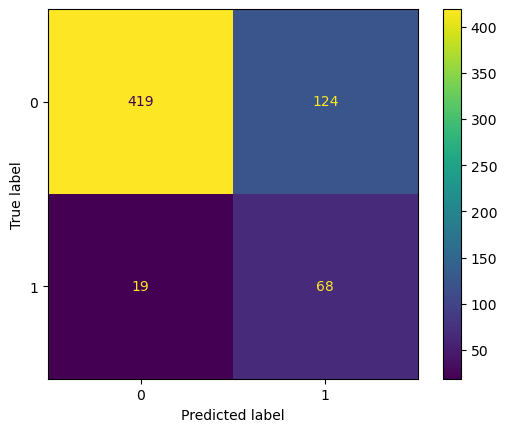



Accuracy:  0.773015873015873
Precision:  0.3541666666666667
Recall:  0.7816091954022989
F1:  0.4874551971326165
AUC:  0.8298088524798374


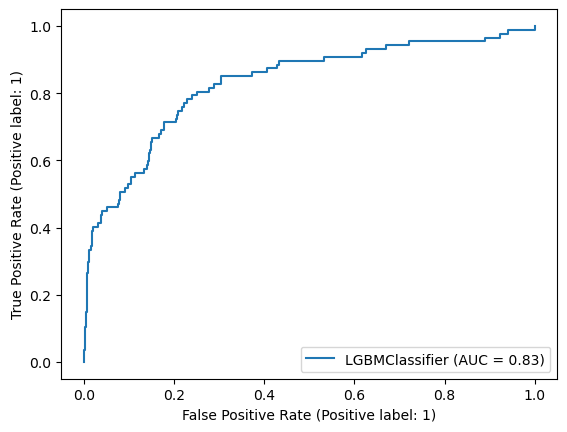

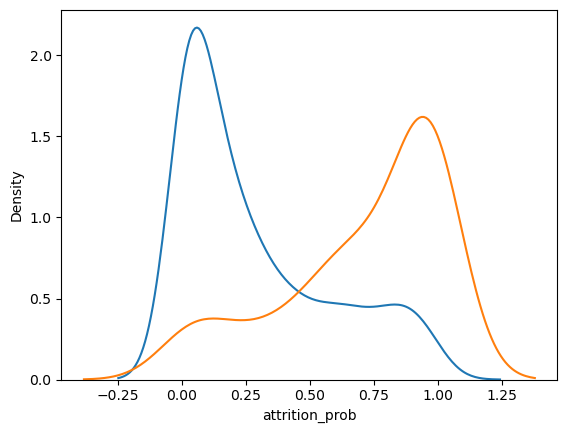

true_class  predicted_class
0           0                  0.771639
            1                  0.228361
1           1                  0.781609
            0                  0.218391
Name: predicted_class, dtype: float64


In [33]:
lgbm_model.fit(x_train_dwn, y_train_dwn)
eval_model(lgbm_model, x_test, y_test)

### Conclusion

Downsampling imporved both the models but LGBM is more stable.
With metrics after downsamplig.

Accuracy isn't the best metric for decision  making. AUC is marginally reduced but there is a dramatic imporvment in Recall, that means our new model is better at detecting the correct Attrition =1 and hence, overfitting is managed.

### Creating The Ensemble Meta-Model

In [34]:
# Combine the base models in a voting classifier
meta_model = VotingClassifier(estimators=[('rfc', rfc_model), ('lgbm', lgbm_model)], voting='soft')
meta_model.fit(x_train_dwn, y_train_dwn)

VotingClassifier(estimators=[('rfc',
                              RandomForestClassifier(max_depth=14,
                                                     n_estimators=40)),
                             ('lgbm', LGBMClassifier())],
                 voting='soft')

## Submission

In [35]:
DataPath = Path('C:/Users/Admin/Documents/Kaggle/PlaygroundSeries/Season3/playground-series-s3e3')
test_df = pd.read_csv(DataPath/'test.csv', index_col='id')

In [65]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1119 entries, 1677 to 2795
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1119 non-null   int64 
 1   BusinessTravel            1119 non-null   object
 2   DailyRate                 1119 non-null   int64 
 3   Department                1119 non-null   object
 4   DistanceFromHome          1119 non-null   int64 
 5   Education                 1119 non-null   int64 
 6   EducationField            1119 non-null   object
 7   EmployeeCount             1119 non-null   int64 
 8   EnvironmentSatisfaction   1119 non-null   int64 
 9   Gender                    1119 non-null   object
 10  HourlyRate                1119 non-null   int64 
 11  JobInvolvement            1119 non-null   int64 
 12  JobLevel                  1119 non-null   int64 
 13  JobRole                   1119 non-null   object
 14  JobSatisfaction      

In [36]:
def get_predictions(test_df):
    test_df= test_df.drop(['EmployeeCount','Over18','StandardHours'],axis=1)
    category_cols= ['BusinessTravel','Department','EducationField','Gender','JobRole','MaritalStatus','OverTime']
    test_df[category_cols] = test_df[category_cols].astype('category')
    test_df[category_cols].dtypes
    features_test=pd.get_dummies(test_df, prefix_sep='_', drop_first=True)
    return features_test

In [37]:
features_test= get_predictions(test_df)

In [38]:
test_preds= []

for test_index in features_test.index:
    preds = meta_model.predict_proba(features_test)
    test_preds.append(preds[:, 1])
    

In [39]:
test_preds = np.stack(test_preds).mean(0)
test_preds

array([0.58253893, 0.62758986, 0.38571964, ..., 0.22809789, 0.22015621,
       0.10292891])

In [40]:
submit_meta = pd.DataFrame(data={'id': test_df.index, 'Attrition': test_preds})
submit_meta.head()

,id,Attrition
0,1677,0.582539
1,1678,0.627590
2,1679,0.385720
3,1680,0.133796
4,1681,0.944678


In [41]:
submit_meta.to_csv('submission.csv', index=False)

In [42]:
# Verify the result 'id' 1681 showing a high probablity to quit
test_df.loc[1681]

Age                                             29
BusinessTravel                   Travel_Frequently
DailyRate                                      464
Department                  Research & Development
DistanceFromHome                                 9
Education                                        1
EducationField                       Life Sciences
EmployeeCount                                    1
EnvironmentSatisfaction                          3
Gender                                        Male
HourlyRate                                      79
JobInvolvement                                   3
JobLevel                                         1
JobRole                      Laboratory Technician
JobSatisfaction                                  4
MaritalStatus                               Single
MonthlyIncome                                 1223
MonthlyRate                                  15178
NumCompaniesWorked                               1
Over18                         

#### The result is in line with our EDA findings.
#### If you find it insightful then please upvote my first entry ever. 
#### Thank you!